# Cambridge ML Commando Course

## Session 2.2 Text Classification with Naïve Bayes

This notebook might not work properly without:
jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000

_One of the most successful applications of Naïve Bayes has been within the field
of Natural Language Processing (NLP). NLP is a field that has been much related
to machine learning, since many of its problems can be formulated as a classification task. Usually, NLP problems have important amounts of tagged data in the form of text documents. This data can be used as a training dataset for machine
learning algorithms.
In this section, we will use Naïve Bayes for text classification; we will have a set of text documents with their corresponding categories, and we will train a Naïve Bayes algorithm to learn to predict the categories of new unseen instances. This simple task has many practical applications; probably the most known and widely used one is spam filtering. In this section we will try to classify newsgroup messages using a dataset that can be retrieved from within scikit-learn. This dataset consists of around 19,000 newsgroup messages from 20 different topics ranging from politics and religion to sports and science_

Start by importing numpy, scikit-learn, and pyplot, the Python libraries we will be using in this chapter. Show the versions we will be using (in case you have problems running the notebooks).

In [ ]:
%pylab inline
import IPython
import sklearn as sk
import numpy as np
from matplotlib import pyplot as plt
print ('IPython version:', IPython.__version__)
print ('numpy version:', np.__version__)
print ('scikit-learn version:', sk.__version__)
print ('matplotlib version:', matplotlib.__version__)

Import the newsgroup Dataset, and explore its structure and data (this could take some time, especially if sklearn has to download the 14MB dataset from the Internet).

If we look at the properties of the dataset, we will find that we have the usual ones: DESCR, data, target, and target_names. The difference now is that data holds a list (of text items), instead of a numpy matrix:


In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

news = fetch_20newsgroups(subset='all')

X = news.data
y = news.target
y_labels = news.target_names
y_targets = news.target

print(len(X), y.shape) # X is a list, y is a numpy array
for yt in range(20): print(yt, y_labels[yt])
    
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=666)

If you look at a random instance, you will see the content of a newsgroup message, and you can get its corresponding category:

In [ ]:
rand_ix = np.random.randint(0, len(news.data))
print (news.data[rand_ix])
category = news.target[rand_ix]
category_name = news.target_names[category]
print (category, category_name)

This function will serve to perform and evaluate a cross validation:

In [4]:
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem
from sklearn import metrics

def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold croos validation iterator of k=5 folds
    print("underway...")
    k_cv = KFold(n_splits=K, shuffle=True, random_state=0)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=k_cv)
    print (scores)
    print (("Mean score: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), sem(scores)))

from sklearn.preprocessing import minmax_scale
def plot_matrix(mx, title="Some Matrix", labels = None):
    plt.set_cmap("jet")
    fig, ax = plt.subplots()
    im = ax.imshow(minmax_scale(mx))
    if labels is not None:
        ax.set_xticks(np.arange(len(labels)))
        ax.set_yticks(np.arange(len(labels)))
        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    for i in range(len(mx)):
        for j in range(len(mx)):
            text = ax.text(j, i, round(mx[i, j],1),
                           ha="center", va="center", color="w")
    ax.set_title(title)
    fig.set_size_inches(6,6)
    plt.show()

def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    
    print ("Accuracy on training set:")
    print (clf.score(X_train, y_train))
    print ("Accuracy on testing set:")
    print (clf.score(X_test, y_test))
    
    y_pred = clf.predict(X_test)
    
    print ("Classification Report:")
    print (metrics.classification_report(y_test, y_pred))
    print ("Confusion Matrix:")
#     print (metrics.confusion_matrix(y_test, y_pred))
    mx = metrics.confusion_matrix(y_test, y_pred)
    plot_matrix(mx, title="Text Classif'n Confusion Mx", features = [y_labels[yt] for yt in range(20)])

Our machine learning algorithms can work only on numeric data...

Inside the `sklearn.feature_extraction.text` module, there are three classes that can transform text into numeric features: `CountVectorizer`, `HashingVectorizer`, and `TfidfVectorizer`.
The difference between them resides in the calculations they perform to derive the numeric features:
- `CountVectorizer` basically creates a dictionary of words from the corpus. Then, each instance is converted to a vector of numeric features where each element will be the frequency of each word in the document.
- `HashingVectorizer`, instead of constructing and maintaining the dictionary in memory, implements a hashing function that maps tokens into feature indexes, and then computes the count as in CountVectorizer.
- `TfidfVectorizer` works like CountVectorizer, with a more advanced calculation called "Term Frequency - Inverse Document Frequency" (TF-IDF). This is a statistic for measuring the importance of a word in a document or corpus. Intuitively, it looks for words that are more frequent in the current document, compared with their frequency across all documents. You can see this as a way to normalize the results and avoid words that are too frequent, and thus not useful to characterise the instances.

We will create a Naïve Bayes classifier that is composed of a feature vectorizer and the actual Bayes classifier. We will use the MultinomialNB class from the `sklearn.naive_bayes` module. 


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer

corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
    ]
cv = CountVectorizer()
txd = cv.fit_transform(corpus)
print(txd.toarray())

hv = HashingVectorizer(norm=None, alternate_sign=False)
txd = hv.transform(corpus)
# print(txd)
print(txd.toarray()) # converting to dense array doesn't help us much

tv = TfidfVectorizer()
txd = tv.fit_transform(corpus)
print(txd.toarray())

clf_class = MultinomialNB()

clf_1 = Pipeline([
    ('vect', cv),
    ('clf', clf_class),
])
clf_2 = Pipeline([
    ('vect', hv),
    ('clf', clf_class),
])
clf_3 = Pipeline([
    ('vect', tv),
    ('clf', clf_class),
])

In [ ]:
clfs = [clf_1, clf_2, clf_3]
for clf in clfs:
    print("for clf {}".format(clf))
    evaluate_cross_validation(clf, X_train, y_train, 2) #just for speed- use more than two in real life!


## Improving our tokenisation

We will keep the TF-IDF vectoriser but use a different regular expression to perform tokenisation. The default regular expression: "\w\w+" considers alphanumeric characters and the underscore. Perhaps also considering the slash and the dot could improve the tokenisation, and begin considering tokens as Wi-Fi and site.com. The new regular expression could be: "[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+". If you have queries about how to define regular expressions, please refer to the Python re module documentation. Let's try our new classifier:

In [ ]:
clf_4 = Pipeline([
    ('vect', TfidfVectorizer(token_pattern="[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+")),
    ('clf', MultinomialNB()),
])
evaluate_cross_validation(clf_4, X_train, y_train, 5)

## Using stopwords

Another parameter that we can use is stop_words: this argument allows us to pass a list of words we do not want to take into account, such as too frequent words, or words we do not a priori expect to provide information about the particular topic. Let's try to improve performance filtering the stop words:

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
sk_stop_words = CountVectorizer(stop_words="english").get_stop_words()

print("NLTK STOPWORDS ({}):\n{}".format(len(stop_words),stop_words))
print("\nSKLEARN STOPWORDS ({}):\n{}".format(len(sk_stop_words),sk_stop_words))

combined_stop_words = set(stop_words).union(set(sk_stop_words))
print("\nCombined stop words ({}):\n{}".format(len(combined_stop_words), combined_stop_words))

## Smoothing, Feature set size, n-gram features

In [ ]:
for MB_smoothing_value in [0.1, ]:# [1.0e-10,0.01,0.1,1]: # this is the default count given to never-seen-before words
    for max_feats in [None,]: # [100, 1000, 10000] # None keeps all the features
        for max_n_gram in [1,3]: # [1,2,3]:
            this_clf = Pipeline([
                ('vect', TfidfVectorizer(
                            ngram_range = (1, max_n_gram),
                            max_features= max_feats,
                            stop_words = combined_stop_words,
                            token_pattern='[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+',    
                )),
                ('clf', MultinomialNB(alpha=MB_smoothing_value)),
            ])
            print("Max features={}, MB smoothing={}, max n_gram={}".format(max_feats, MB_smoothing_value, max_n_gram))
            evaluate_cross_validation(this_clf, X_train, y_train, 2)

## Checking out the features we are using

In [ ]:
clf_7 = Pipeline([
            ('vect', TfidfVectorizer(
                ngram_range = (1,3),
                max_features= None,
                stop_words = combined_stop_words,
                token_pattern='[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+',    
            )),
            ('clf', MultinomialNB(alpha=0.1)),
        ])

tfidf_vect = clf_7.named_steps['vect']
X_txd = tfidf_vect.fit_transform(X_train)

### We can extract the n-gram analyser and feature set from the pipeline
If we look inside the vectorizer, we can see which tokens have been used to create our vocabulary

In [ ]:
analyser = tfidf_vect.build_analyzer()
print(analyser("A sequence of not very interesting words to tokenise"))

In [ ]:
feats = tfidf_vect.get_feature_names()
for ft in feats[0:100]:
    print(ft)
print(len(feats))
del feats

At this point, we could continue doing trials by using different values of alpha or doing new modifications of the vectorizer.

If we decide that we have made enough improvements in our model, we are ready to evaluate its performance on the testing set.

In [ ]:
train_and_evaluate(clf_7, X_train, X_test, y_train, y_test)

As we can see, we obtained very good results, and as we would expect, the accuracy in the training set is rather better than in the testing set. We may expect, in new unseen instances, an accuracy of around 0.91.

## Visualising our dataset
If we are interested in seeing our dataset, as captured by our feature extraction, then we need a way to reduce the dimensionality of the data from a vast number, to 2.  We can use TSNE to create a nice cluster plot, but it is computationally expensive, so to speed things up a bit we do (cheap and fast) PCA first, to reduce the dimensions to a more manageable amount.

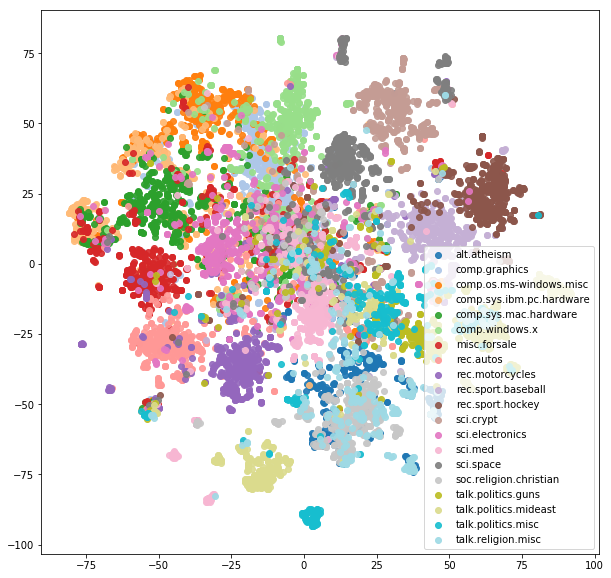

In [186]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
plt.figure(figsize=(10,10))

clip_at = 10000
tx_unigram = TfidfVectorizer(
                ngram_range = (1,1), # you can try bigger values and blow up your computer
                max_features= None,
                stop_words = combined_stop_words,
                token_pattern='[a-z0-9_\-\.]+[a-z][a-z0-9_\-\.]+',    
            )

X_clip = X_train[0:clip_at]
y_clip = y_train[0:clip_at]
X_txd = tx_unigram.fit_transform(X_clip)

svd = TruncatedSVD(n_components=64) # Like PCA for sparse matrices
X_2d = svd.fit_transform(X_txd)
tsne = TSNE(n_components=2) # Emphasises clusters
X_2d = tsne.fit_transform(X_2d)
plt.set_cmap("tab20")
cm = plt.get_cmap()
# labs_to_plot = [y_labels[ix] for ix in y_train[0:clip_at]]
ax = plt.gca()
for yt in range(20):
    this_c = [cm(yt/20)]
    name = y_labels[yt]
    class_filter = numpy.where(y_clip == yt)
    plt.scatter(X_2d[class_filter,0], X_2d[class_filter,1], alpha=0.9, label=name, c=this_c)
plt.legend()
plt.show()

## For the keen:  Named-entity recognition (NER) with NLTK
The NLTK code below will extract named entities from the documents.  Can you use these to drive the classifier?  Does it work better, worse?  Why do you think?

In [ ]:
import nltk
from nltk import ne_chunk, tokenize, PorterStemmer
nltk.download('treebank')
nltk.download('maxent_ne_chunker')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

entities_per_doc = [] # the i-th element gives a summary of the named entities found in the i-th document
doc_n=0
print(len(news.data))
for doc in news.data:# nltk.corpus.treebank.tagged_sents():
    doc_entities = []
    doc = nltk.sent_tokenize(doc)
    doc = [nltk.wordpunct_tokenize(sent) for sent in doc]
    doc = [nltk.pos_tag(sent) for sent in doc]
    for s in doc:        
        chunx = ne_chunk(s, binary=True)
        for chunk in chunx:
            if hasattr(chunk, 'label'):
                doc_entities.extend([c[0] for c in chunk])
    print(doc_entities)
    entities_per_doc.append(" ".join(doc_entities))

## Summary
- We loaded the 1993 Newsgroups dataset and split it into train/test sets
- We preprocessed the raw text using various Vectorisers arranged in Pipelines
- We used Multinomial Naive Bayes to classify the articles
- We used 5-fold cross validation to check our performance
- We made some optimisations and tested on a held-out test set
- We (optionally) played with named entity recognition to see if that would help